<a href="https://colab.research.google.com/github/monica-raluca/ML/blob/main/lab/lab7/Laborator_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Învățare Automată
# Învățare prin Recompensă - Algoritmul Q-learning
### Autori:
* Tudor Berariu - 2016
* George Muraru - 2020

## 1. Scopul laboratorului

Scopul laboratorului îl reprezintă ̆întelegerea și implementarea algoritmului Q-Learning.

# 2. Algoritmul Q-Learning

![Q-learning](https://github.com/cs-pub-ro/ML/blob/master/lab/lab7/img/q-learning.jpg?raw=true)

## 3. Workspace Setup


### Câteva biblioteci de care vom avea nevoie

In [1]:
from copy import deepcopy
from random import choice, random
from time import sleep
import urllib.request

from IPython.display import clear_output

## Parametrii necesari rulării

In [8]:
# File to read map from
MAP_NAME = "mini_map" #@param ["mini_map", "big_map", "huge_map"]

# Meta-parameters

LEARNING_RATE = 0.1 #@param {type: "slider", min: 0.001, max: 1.0, step: 0.01}
DISCOUNT_FACTOR = 0.99 #@param {type: "slider", min: 0.01, max: 1.0, step: 0.01}

# Probabilit to choose a random action
EPSILON = 0.05 #@param {type: "slider", min: 0.0, max:1.0, step: 0.05, default: 0.05}


# Training and evaluation episodes
TRAIN_EPISODES = 1000 #@param {type: "slider", min: 1, max: 20000, default: 1000}

# Evaluate after specified number of episodes
EVAL_EVERY = 10 #@param {type: "slider", min: 0, max: 1000}

# Evaluate using the specified number of episodes
EVAL_EPISODES = 10 #@param {type: "slider", min: 1, max: 1000}

# Display
VERBOSE = False #@param {type: "boolean"}
PLOT_SCORE = True #@param {type: "boolean"}
SLEEP_TIME = 1 #@param {type: "slider", min:1, max:10}

# Show the end result
FINAL_SHOW = True #@param {type: "boolean"}

### Clasă care abstractizează jocul

In [9]:
URL_PREFIX = "https://raw.githubusercontent.com/cs-pub-ro/ML/master/lab/lab7/maps/"

ACTIONS = ["UP", "RIGHT", "DOWN", "LEFT", "STAY"]

ACTION_EFFECTS = {
    "UP": (-1,0),
    "RIGHT": (0,1),
    "DOWN": (1,0),
    "LEFT": (0,-1),
    "STAY": (0,0)
}

MOVE_REWARD = -0.1
WIN_REWARD = 10.0
LOSE_REWARD = -10.0

## Functions to serialize / deserialize game states
def __serialize_state(state):
    return "\n".join(map(lambda row: "".join(row), state))

def __deserialize_state(str_state):
    return list(map(list, str_state.split("\n")))

## Return the initial state of the game
def get_initial_state(map_file_name):
    full_url = f"{URL_PREFIX}{MAP_NAME}"
    state = urllib.request.urlopen(full_url).read().strip()

    return state.decode("utf-8")

## Get the coordinates of an actor
def __get_position(state, marker):
    for row_idx, row in enumerate(state):
        if marker in row:
            return row_idx, row.index(marker)
    return -1, -1

## Check if is a final state
def is_final_state(str_state, score):
    return score < -20.0 or "G" not in str_state or "o" not in str_state

## Check if the given coordinates are valid (on map and not a wall)
def __is_valid_cell(state, row, col):
    return row >= 0 and row < len(state) and \
        col >= 0 and col < len(state[row]) and \
        state[row][col] != "*"

## Move to next state
def apply_action(str_state, action):
    assert(action in ACTIONS)
    message = "Greuceanu moved %s." % action

    state = __deserialize_state(str_state)
    g_row, g_col = __get_position(state, "G")
    assert(g_row >= 0 and g_col >= 0)

    next_g_row = g_row + ACTION_EFFECTS[action][0]
    next_g_col = g_col + ACTION_EFFECTS[action][1]

    if not __is_valid_cell(state, next_g_row, next_g_col):
        next_g_row = g_row
        next_g_col = g_col
        message = f"{message} Not a valid cell there."

    state[g_row][g_col] = " "
    if state[next_g_row][next_g_col] == "B":
        message = f"{message} Greuceanu stepped on the balaur."
        return __serialize_state(state), LOSE_REWARD, message
    elif state[next_g_row][next_g_col] == "o":
        state[next_g_row][next_g_col] = "G"
        message = f"{message} Greuceanu found 'marul fermecat'."
        return __serialize_state(state), WIN_REWARD, message
    state[next_g_row][next_g_col] = "G"

    ## Balaur moves now
    b_row, b_col = __get_position(state, "B")
    assert(b_row >= 0 and b_col >= 0)

    dy, dx = next_g_row - b_row, next_g_col - b_col

    is_good = lambda dr, dc:__is_valid_cell(state, b_row + dr, b_col + dc)

    next_b_row, next_b_col = b_row, b_col
    if abs(dy) > abs(dx) and is_good(dy // abs(dy), 0):
        next_b_row = b_row + dy // abs(dy)
    elif abs(dx) > abs(dy) and is_good(0, dx // abs(dx)):
        next_b_col = b_col + dx // abs(dx)
    else:
        options = []
        if abs(dx) > 0:
            if is_good(0, dx // abs(dx)):
                options.append((b_row, b_col + dx // abs(dx)))
        else:
            if is_good(0, -1):
                options.append((b_row, b_col - 1))
            if is_good(0, 1):
                options.append((b_row, b_col + 1))
        if abs(dy) > 0:
            if is_good(dy // abs(dy), 0):
                options.append((b_row + dy // abs(dy), b_col))
        else:
            if is_good(-1, 0):
                options.append((b_row - 1, b_col))
            if is_good(1, 0):
                options.append((b_row + 1, b_col))

        if len(options) > 0:
            next_b_row, next_b_col = choice(options)

    if state[next_b_row][next_b_col] == "G":
        message = f"{message} The balaur ate Greuceanu."
        reward = LOSE_REWARD
    elif state[next_b_row][next_b_col] == "o":
        message = f"{message} The balaur found marul fermecat. Greuceanu lost!"
        reward = LOSE_REWARD
    else:
        message = f"{message} The balaur follows Greuceanu."
        reward = MOVE_REWARD

    state[b_row][b_col] = " "
    state[next_b_row][next_b_col] = "B"

    return __serialize_state(state), reward, message

def display_state(state):
    print(state)

# 3. Problemă de rezolvat
## Greuceanu și Balaurul

Pe o hartă bidimensională se înfruntă Greuceanu și-un balaur.

Greuceanu trebuie să găsească mărul fermecat înainte de a fi prins de balaur și înainte ca balaurul să calce pe măr. Balaurul simte direcția în care se află Greuceanu și se îndreaptă către el.

Concret, Greuceanu **câștigă** jocul și 10 puncte dacă ajunge primul la mărul fermecat.

Greuceanu **pierde** jocul dacă este prins de balaur sau dacă balaurul calcă pe măr. Deasemenea, la fiecare moment de timp Greuceanu pierde câte 0.1 puncte.

Dacă **ajunge la -20 de puncte**, Greuceanu pierde jocul.

## 4. Cerințe

1. [6 pct] Implementați algoritmul Q-learning (completași funcția **q_learning**).

2. [2 pct] Implementați strategia-greedy de selecție a unei acțiuni. Funcția primește toate acțiunile valide dintr-o stare dată. Atât timp cât există acțiuni ce nu au fost explorate, se va alege aleator una dintre acestea.
Altfel, cu o probabilitate $\epsilon$ se va alege o acțiune aleatoare, iar cu o probabilitate 1 − $\epsilon$ se va alege cea mai bună acțiune din starea respectivă.


3. [2 pct] Implementați rutina de evaluare a politicii lacome (care alege întotdeauna cea mai bună acțiune).

4. [2 pct] Găsiți metaparametrii potriviți pentru o învățare cât mai rapidă pe toate cele trei hărți (rata de învățare, valoarea lui $\epsilon$). Încercați să modificați $\epsilon$ pe parcursul învățarii.

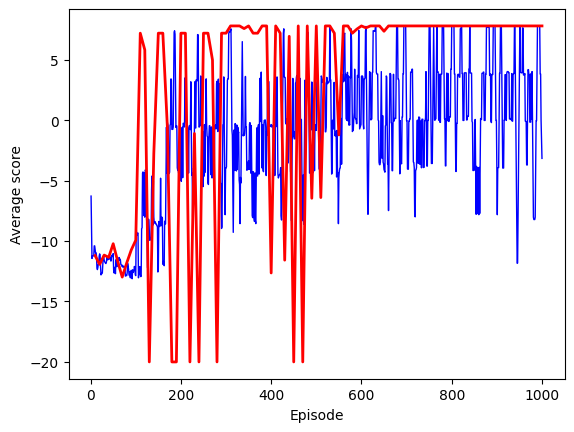

In [10]:
def get_legal_actions(str_state):
    #TODO (1) : Get the actions Greuceanu can do
    # return deepcopy(ACTIONS)
    state = __deserialize_state(str_state)
    g_row, g_col = __get_position(state, "G")

    legal_actions = []
    for action, (dr, dc) in ACTION_EFFECTS.items():
        new_row, new_col = g_row + dr, g_col + dc
        if __is_valid_cell(state, new_row, new_col):
            legal_actions.append(action)
    return legal_actions

def epsilon_greedy(Q, state, legal_actions, epsilon):
    # TODO (2) : Epsilon greedy
    # return choice(legal_actions)
    unexplored = [a for a in legal_actions if (state, a) not in Q]
    if unexplored:
        return choice(unexplored)
    if random() < epsilon:
        return choice(legal_actions)
    return best_action(Q, state, legal_actions)

def best_action(Q, state, legal_actions):
    # TODO (3) : Best action
    # return choice(legal_actions)
    q_values = [Q.get((state, a), 0.0) for a in legal_actions]
    max_q = max(q_values)
    best_actions = [a for a, q in zip(legal_actions, q_values) if q == max_q]
    return choice(best_actions)

def q_learning():
    global EPSILON

    Q = {}
    train_scores = []
    eval_scores = []
    initial_state = get_initial_state(MAP_NAME)

    EPSILON_DECAY = 0.997
    MIN_EPSILON = 0.05

    for train_ep in range(1, TRAIN_EPISODES+1):
        clear_output(wait=True)
        score = 0
        state = deepcopy(initial_state)

        if VERBOSE:
            display_state(state); sleep(SLEEP_TIME)
            clear_output(wait=True)

        while not is_final_state(state, score):

            actions = get_legal_actions(state)
            action = epsilon_greedy(Q, state, actions, EPSILON)

            old_state = state
            state, reward, msg = apply_action(state, action)
            score += reward

            # TODO (1) : Q-Learning
            next_actions = get_legal_actions(state)
            if len(next_actions) == 0:
                max_next_q = 0.0
            else:
                max_next_q = max([Q.get((state, a), 0.0) for a in next_actions])

            current_q = Q.get((old_state, action), 0.0)
            Q[(old_state, action)] = current_q + LEARNING_RATE * (reward + DISCOUNT_FACTOR * max_next_q - current_q)

            if VERBOSE:
                print(msg); display_state(state); sleep(SLEEP_TIME)
                clear_output(wait=True)


        print(f"Episode {train_ep} / {TRAIN_EPISODES}")
        train_scores.append(score)

        # evaluate the greedy policy
        if train_ep % EVAL_EVERY == 0:
            avg_score = .0

            # TODO (4) : Evaluate
            for eval_ep in range(EVAL_EPISODES):
                eval_state = deepcopy(initial_state)
                eval_score = 0.0

                while not is_final_state(eval_state, eval_score):
                    eval_actions = get_legal_actions(eval_state)
                    eval_action = best_action(Q, eval_state, eval_actions)

                    eval_state, reward, msg = apply_action(eval_state, eval_action)
                    eval_score += reward

                avg_score += eval_score

            avg_score /= EVAL_EPISODES
            eval_scores.append(avg_score)

        EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

    # --------------------------------------------------------------------------
    if FINAL_SHOW:
        state = deepcopy(initial_state)
        while not is_final_state(state, score):
            action = best_action(Q, state, get_legal_actions(state))
            state, _, msg = apply_action(state, action)
            print(msg); display_state(state); sleep(SLEEP_TIME)
            clear_output(wait=True)

    if PLOT_SCORE:
        from matplotlib import pyplot as plt
        import numpy as np
        plt.xlabel("Episode")
        plt.ylabel("Average score")
        plt.plot(
            np.linspace(1, TRAIN_EPISODES, TRAIN_EPISODES),
            np.convolve(train_scores, [0.2,0.2,0.2,0.2,0.2], "same"),
            linewidth = 1.0, color = "blue"
        )
        plt.plot(
            np.linspace(EVAL_EVERY, TRAIN_EPISODES, len(eval_scores)),
                        eval_scores, linewidth = 2.0, color = "red"
        )
        plt.show()

q_learning()